## ASESOR ECONOMICO (riesgo de fuga de una empresa)

# Importaciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Parte 1

In [3]:
# Cargar dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Eliminar ID
df.drop('customerID', axis=1, inplace=True)

# Limpiar TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


df = pd.get_dummies(df, drop_first=True)


X = df.drop('Churn_Yes', axis=1)
y = df['Churn_Yes']


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

/tmp/ipython-input-3478998642.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


# Parte 2 Modelos

Logistic Regression

In [4]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression")
print(classification_report(y_test, y_pred_log))


Logistic Regression
              precision    recall  f1-score   support

       False       0.85      0.89      0.87      1035
        True       0.66      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



Random Forest

In [5]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))


Random Forest
              precision    recall  f1-score   support

       False       0.83      0.89      0.86      1035
        True       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



Clasificacion de Riesgo

In [6]:
# Probabilidad de fuga (clase 1 = churn)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

def risk_level(prob):
    if prob >= 0.80:
        return "Alto Riesgo"
    elif prob >= 0.50:
        return "Riesgo Medio"
    else:
        return "Bajo Riesgo"

risk_levels = [risk_level(p) for p in y_proba_rf]


Resultado

In [7]:
results = X_test.copy()
results['Probabilidad_Fuga'] = y_proba_rf
results['Nivel_Riesgo'] = risk_levels
results['Fuga_Real'] = y_test.values

results.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Probabilidad_Fuga,Nivel_Riesgo,Fuga_Real
437,0,72,114.05,8468.20,True,True,True,True,False,True,...,True,False,True,True,True,False,False,0.00,Bajo Riesgo,False
2280,1,8,100.15,908.55,False,False,False,True,False,True,...,True,False,False,True,True,False,False,0.79,Riesgo Medio,False
2235,0,41,78.35,3211.20,False,True,True,True,False,True,...,False,True,False,True,True,False,False,0.09,Bajo Riesgo,False
4460,0,18,78.20,1468.75,True,True,False,True,False,False,...,False,False,False,False,False,True,False,0.29,Bajo Riesgo,False
3761,0,72,82.65,5919.35,False,True,False,True,False,True,...,True,False,True,True,True,False,False,0.00,Bajo Riesgo,False


Recomendaciones

In [8]:
def economic_recommendation(row):
    if row['Nivel_Riesgo'] == 'Alto Riesgo':
        return "Ofrecer descuento o plan personalizado"
    elif row['Nivel_Riesgo'] == 'Riesgo Medio':
        return "Seguimiento y mejora en atención al cliente"
    else:
        return "Mantener estrategia actual"

results['Recomendacion_Economica'] = results.apply(economic_recommendation, axis=1)


Impacto economico

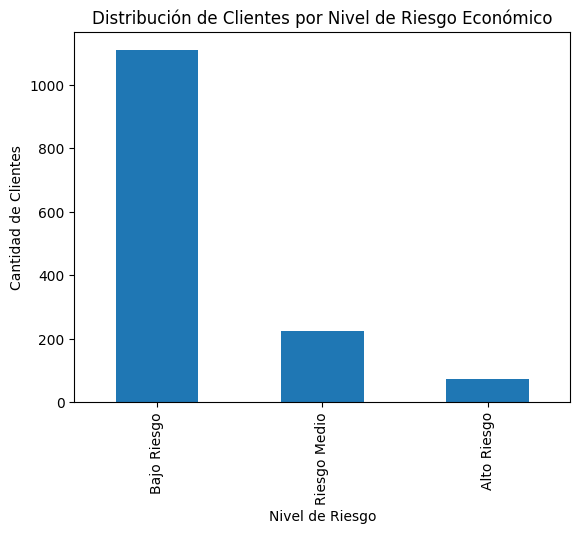

In [9]:
results['Nivel_Riesgo'].value_counts().plot(kind='bar')
plt.title("Distribución de Clientes por Nivel de Riesgo Económico")
plt.ylabel("Cantidad de Clientes")
plt.xlabel("Nivel de Riesgo")
plt.show()


Importancia de variables

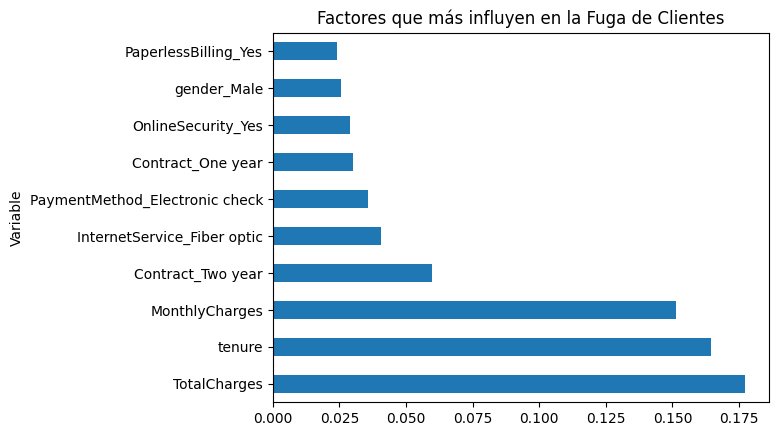

In [10]:
importances = rf_model.feature_importances_

feature_importance = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

feature_importance.head(10)


feature_importance.head(10).plot(
    kind='barh',
    x='Variable',
    y='Importancia',
    legend=False
)

plt.title("Factores que más influyen en la Fuga de Clientes")
plt.show()


DEMO

In [11]:
summary = results['Nivel_Riesgo'].value_counts(normalize=True) * 100
summary


,proportion
Nivel_Riesgo,
Bajo Riesgo,78.779276
Riesgo Medio,15.968772
Alto Riesgo,5.251952


## Preparación del Asesor Económico en Tiempo Real
En esta sección se prepara el modelo entrenado para su uso en una interfaz interactiva.


In [12]:
import joblib

# Guardar modelo y features
joblib.dump(rf_model, "model.pkl")
joblib.dump(X.columns.tolist(), "features.pkl")

print("Modelo y variables guardados correctamente")


Modelo y variables guardados correctamente
